# **EMNIST DATASET**

**PROFESSORS:**

Alberto Testolin
Marco Zorzi

**COURSE:**

COGNITION AND COMPUTATION

**NAME:**

Brenda Eloísa Téllez Juárez

**STUDENT'S NUMBER:**

2041498

**CAPSTONE PROJECT WINTER 2023**

**DESCRIPTION OF THE DATASET**

The EMNIST dataset has evolved into a gold standard for learning, classification, and computer vision systems. The database's accessibility and ease of use contribute to its widespread adoption. \\
The dataset is divided into the following: EMNIST ByClass, EMNIST ByMerge, EMNIST Balanced, EMNIST Letters, EMNIST Digits, and EMNIST MNIST.
In the development of this work is used the EMNIST Balanced, which consists of 31,600 characters and 47 balanced classes, and contains a set of characters with an equal number of samples per class.

**OBJECTIVE**

The primary goal of this work is to create a BDN to observe the hierarchical representations of the features, as well as a FNN to compare the performance of the models and assess their resistance to noise and adversarial attacks.


**Libraries**

In [ ]:
def get_dbn_library():
  files = ["DBN.py", "RBM.py"]
  repository_url = "https://raw.githubusercontent.com/flavio2018/Deep-Belief-Network-pytorch/master/"
  for file in files:
    ! wget -O {file} {repository_url}{file}

In [ ]:
%%capture
get_dbn_library()

In [ ]:
import math
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision as tv
import torch.nn.functional as functional
from tqdm.notebook import tqdm
from DBN import DBN

In [ ]:
!pip install ipywidgets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 70.8 MB/s eta 0:00:00


Let's choose dynamically the kind of device used for computations (CPU or GPU).

In [ ]:
print(torch.cuda.is_available())
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

True


**Adding the dataset**

In [ ]:
%%capture
emnist_train = tv.datasets.EMNIST('data/', train=True, download=True, split='balanced',
                                         transform=tv.transforms.Compose(
                                                  [tv.transforms.ToTensor()]
                                         ))

emnist_test = tv.datasets.EMNIST("data/",
                                train=False,
                                download=True,
                                split="balanced",
                                transform=tv.transforms.Compose(
                                        [tv.transforms.ToTensor()]
                                ))

In [ ]:
emnist_train.data = (emnist_train.data.type(torch.FloatTensor)/255)
emnist_test.data = (emnist_test.data.type(torch.FloatTensor)/255)

In [ ]:
emnist_train.data = emnist_train.data.to(device)
emnist_test.data = emnist_test.data.to(device)
emnist_train.targets = emnist_train.targets.to(device)
emnist_test.targets = emnist_test.targets.to(device)

## **Deep Belief Network**

The goal of a Deep Belief Network (DBN) is to learn and understand data patterns. This is accomplished by training multiple layers, each of which learns to recognize and represent more complex patterns in the data. The first stage of training involves unsupervised learning to train each layer, followed by labeled data to fine-tune the network for specific tasks such as prediction or classification. The end result is a multi-layer neural network capable of making predictions based on the patterns discovered in the data.

In [ ]:
dbn_emnist = DBN(visible_units=28*28,
                hidden_units=[400, 500, 800],
                k=1,
                learning_rate=0.1,
                learning_rate_decay=False,
                initial_momentum=0.5,
                final_momentum=0.95,
                weight_decay=0.0001,
                xavier_init=False,
                increase_to_cd_k=False,
                use_gpu=torch.cuda.is_available())

The DBN has 28x28 visible units (image pixels of 28x28) and three hidden layers of 400, 500, and 800 units. The network trains using contrastive divergence with k=1 and has a learning rate of 0.1. The network's momentum begins at 0.5 and gradually increases to 0.95. The weight decay is set to 0.0001, and no Xavier initialization is used. The computations are performed on a GPU.

In [ ]:
num_epochs = 50
batch_size = 125

dbn_emnist.train_static(
    emnist_train.data,
    emnist_train.targets,
    num_epochs,
    batch_size
)

--------------------
Training RBM layer 1
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |1.3772     |0.0418       |341.7620   |4.9686     |
|20    |1.3153     |0.0400       |324.5097   |5.0134     |
|30    |1.3048     |0.0415       |320.4977   |5.0402     |
|40    |1.3013     |0.0402       |319.8418   |4.7640     |
|50    |1.2967     |0.0399       |317.3332   |5.2190     |
--------------------
Training RBM layer 2
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |1.6301     |0.0432       |224.7444   |2.8573     |
|20    |1.5694     |0.0417       |219.6446   |3.0283     |
|30    |1.5564     |0.0419       |218.0573   |2.7012     |
|40    |1.5512     |0.0416       |218.0761   |2.9994     |
|50    |1.5494     |0.0395       |217.6292   |3.0661     |
--------------------
Training RBM layer 3
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |1.1501     |0.0329       |265.3364   |3.6220     |
|20    |1.0741     |0.0305       |251.1431   |3.820

Training is divided into three stages, one for each hidden layer. The batch size is 125 and the number of training epochs is set to 50. For each hidden layer at each epoch, the output displays the average reconstruction error, standard deviation of reconstruction error, mean gradient, and standard deviation of gradient. The reconstruction error and gradients are indicators of how well the network can reconstruct the input data, and their values decrease as training progresses.

The reconstruction error of the first hidden layer starts at 1.3772 and the standard deviation is 0.0418, and it decreases to 1.2967 and 0.0399 at the end of the training. The mean gradient starts at 341.7620 and the standard deviation is 4.9686, and it decreases to 317.3332. The second layer begins with a reconstruction error of 1.6301 and a standard deviation of 0.0432 and decreases to 1.5494 and 0.0395 at the end of training, while the mean gradient begins at 224.7444 and decreases to 217.6292. The third layer, starts with a reconstruction error of 1.1501 and standard deviation of 0.0329and it decreases to 1.0580  and 0.0286  at the end of the training, the mean gradient starts at 265.3364 and standard deviation of 3.6220 and it decreases to 248.1279.

##**Linear read-out**

The linear readout is the final step in a DBN that combines the information from previous layers to make a prediction. It uses a simple mathematical formula to combine the information and produce a single output. This is often used in regression problems where the answer is a continuous value. The formula used is optimized during training to improve the accuracy of the predictions.

In [ ]:
def get_kth_layer_repr(input, k, device):
  flattened_input = input.view((input.shape[0], -1)).type(torch.FloatTensor).to(device)
  hidden_repr, __ = dbn_emnist.rbm_layers[k].to_hidden(flattened_input)  # here we access the RBM object
  return hidden_repr

This code defines the function "get kth layer repr," which takes three arguments: input, k (hidden layer index), and device (GPU or CPU).
The function flattens the tensor input. The input is then sent to the device. The function then invokes the "to hidden" method of the DBN's kth RBM object. The method returns the hidden representation of the input, which serves as the function's output.

In [ ]:
hidden_repr_layer_1 = get_kth_layer_repr(emnist_train.data, 0, device)
hidden_repr_layer_2 = get_kth_layer_repr(hidden_repr_layer_1, 1, device)
hidden_repr_layer_3 = get_kth_layer_repr(hidden_repr_layer_2, 2, device)

It calls the function "get kth layer repr" three times, passing in the train data each time. In each call, data is used as the input, the index of the hidden layer (0,1,2 respectively), and goes to the device.
We can use these hidden representations to classify the images.

In [ ]:
class LinearModel(torch.nn.Module):
  def __init__(self, last_layer_size):
    super().__init__()
    self.linear = torch.nn.Linear(last_layer_size, 47)

  def forward(self, x):
    return self.linear(x)

This code declares the "LinearModel" class. This class defines a simple linear model for classification tasks using the balanced dataset's 47 classes.
The class also defines a forward method that takes the input tensor as an argument, applies the linear layer to it, and returns the result.
This linear model can be trained on the hidden representations obtained from the layers and used to classify the images.

In [ ]:
layer_size = dbn_emnist.rbm_layers[0].W.shape[1]
linear1 = LinearModel(layer_size).to(device)

layer_size = dbn_emnist.rbm_layers[1].W.shape[1]
linear2 = LinearModel(layer_size).to(device)

layer_size = dbn_emnist.rbm_layers[2].W.shape[1]
linear3 = LinearModel(layer_size).to(device)

This code generates three instances of the "LinearModel" class, one for each of the DBN's hidden layers.
This linear model can be trained and used to classify images using the hidden representations obtained from the various layers.

In [ ]:
def train(network, input, epochs=1500):
  optimizer = torch.optim.SGD(network.parameters(), lr=0.05)
  loss_fn = torch.nn.CrossEntropyLoss()

  for epoch in range(epochs):
    optimizer.zero_grad()
    predictions = network(input).squeeze()
    targets = emnist_train.targets.reshape(predictions.shape[0])  # here are the labels
    loss = loss_fn(predictions, targets)
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
      print("epoch : {:3d}/{}, loss = {:.4f}".format(epoch + 1, epochs, loss))

This function train is used to train a neural network. It takes four arguments: the network, inputs, targets, and epochs (in this case, 1500).
The function begins by defining an optimizer (SGD with a learning rate of 0.05) and a loss function (cross-entropy loss).
Every 100 epochs, the code prints the current epoch number as well as the loss value. This allows to assess the progress of the training process and determine whether the network is overfitting or underfitting.

In [ ]:
train(linear1, hidden_repr_layer_1)
train(linear2, hidden_repr_layer_2)
train(linear3, hidden_repr_layer_3)

epoch :   1/1500, loss = 3.8689
epoch : 101/1500, loss = 3.0515
epoch : 201/1500, loss = 2.5297
epoch : 301/1500, loss = 2.1926
epoch : 401/1500, loss = 1.9681
epoch : 501/1500, loss = 1.8118
epoch : 601/1500, loss = 1.6979
epoch : 701/1500, loss = 1.6111
epoch : 801/1500, loss = 1.5426
epoch : 901/1500, loss = 1.4868
epoch : 1001/1500, loss = 1.4403
epoch : 1101/1500, loss = 1.4006
epoch : 1201/1500, loss = 1.3662
epoch : 1301/1500, loss = 1.3359
epoch : 1401/1500, loss = 1.3091
epoch :   1/1500, loss = 3.8766
epoch : 101/1500, loss = 3.0087
epoch : 201/1500, loss = 2.4746
epoch : 301/1500, loss = 2.1429
epoch : 401/1500, loss = 1.9283
epoch : 501/1500, loss = 1.7813
epoch : 601/1500, loss = 1.6749
epoch : 701/1500, loss = 1.5940
epoch : 801/1500, loss = 1.5300
epoch : 901/1500, loss = 1.4778
epoch : 1001/1500, loss = 1.4340
epoch : 1101/1500, loss = 1.3966
epoch : 1201/1500, loss = 1.3641
epoch : 1301/1500, loss = 1.3355
epoch : 1401/1500, loss = 1.3100
epoch :   1/1500, loss = 3.860

We have linear models, linear1, linear2, and linear3, using the hidden representations of the first, second, and third layers of a pre-trained model respectively. The input for each linear model is the hidden representation of the corresponding layer, and the targets are the labels of the training data. The training process is done using stochastic gradient descent (SGD) as the optimization algorithm and cross-entropy loss as the loss function. The training process is performed for 1500 epochs and the loss is printed every 100 epochs.

In [ ]:
hidden_repr_layer_1_test = get_kth_layer_repr(emnist_test.data, 0, device)
hidden_repr_layer_2_test = get_kth_layer_repr(hidden_repr_layer_1_test, 1, device)
hidden_repr_layer_3_test = get_kth_layer_repr(hidden_repr_layer_2_test, 2, device)

These variables, "hidden_repr_layer_1_test", "hidden_repr_layer_2_test" and "hidden_repr_layer_3_test" store the hidden representations of the test data at different layers in the DBN.

In [ ]:
# here we compute the predictions
predictions_test1 = linear1(hidden_repr_layer_1_test)
predictions_test2 = linear2(hidden_repr_layer_2_test)
predictions_test3 = linear3(hidden_repr_layer_3_test)

Here the linear models created earlier are applied to the hidden representations of the test data, and the predictions are stored in the variables.
These predictions can then be compared to the true labels of the test data to evaluate the performance of the linear models.

In [ ]:
def compute_accuracy(predictions_test, targets):
  predictions_indices = predictions_test.max(axis=1).indices  # convert probabilities to indices
  accuracy = (predictions_indices == targets).sum() / len(targets)
  return accuracy.item()

The function "compute_accuracy" that takes in two arguments the predictions_test and the targets.
It converts the predictions from a probability distribution to the indices of the classes that have the highest probability, and compares these indices to the true labels and average of the correct predictions. This average represents the accuracy of the predictions.

In [ ]:
compute_accuracy(predictions_test1, emnist_test.targets)

0.6639893651008606

In [ ]:
compute_accuracy(predictions_test2, emnist_test.targets)

0.6597872376441956

In [ ]:
compute_accuracy(predictions_test3, emnist_test.targets)

0.6828723549842834

The accuracy for the fist is 66.39%, for the second is 65.97%, and for the third is 68.28%.

## **Comparison with a feed-forward model**

In [ ]:
class Feedforward(torch.nn.Module):
  def __init__(self, first_hidden_layer_size, second_hidden_layer_size, third_hidden_layer_size):
    super().__init__()
    self.first_hidden = torch.nn.Linear(784, first_hidden_layer_size)
    self.second_hidden = torch.nn.Linear(first_hidden_layer_size, second_hidden_layer_size)
    self.third_hidden = torch.nn.Linear(second_hidden_layer_size, third_hidden_layer_size)
    self.output = torch.nn.Linear(third_hidden_layer_size, 47)

  def forward(self, input):
    relu = torch.nn.ReLU()
    first_hidden_repr = relu(self.first_hidden(input))
    second_hidden_repr = relu(self.second_hidden(first_hidden_repr))
    third_hidden_repr = relu(self.third_hidden(second_hidden_repr))
    output = self.output(third_hidden_repr)
    return output

It defines a Feedforward neural network for classification tasks with 47 classes. It takes in the input as an argument and applies the Linear layers to it with a non-linear activation function ReLU after each linear layer and returns the output.

In [ ]:
ffnn = Feedforward(400, 500, 800).to(device)

We choose the number of epochs to match the training time of the DBN and the readout layer combined.

In [ ]:
train(ffnn, emnist_train.data.reshape((112800, 784)), epochs=1500)

epoch :   1/1500, loss = 3.8501
epoch : 101/1500, loss = 3.8339
epoch : 201/1500, loss = 3.7947
epoch : 301/1500, loss = 3.6239
epoch : 401/1500, loss = 2.9653
epoch : 501/1500, loss = 2.2127
epoch : 601/1500, loss = 1.8017
epoch : 701/1500, loss = 1.6084
epoch : 801/1500, loss = 1.4824
epoch : 901/1500, loss = 1.3972
epoch : 1001/1500, loss = 1.3279
epoch : 1101/1500, loss = 1.2690
epoch : 1201/1500, loss = 1.2185
epoch : 1301/1500, loss = 1.1739
epoch : 1401/1500, loss = 1.1333


In [ ]:
predictions_ffnn = ffnn(emnist_test.data.reshape((18800, 784)))

In [ ]:
compute_accuracy(predictions_ffnn, emnist_test.targets)

0.6788297891616821

We can observe that the accuracy of the FNN is 67.88%.

## **Robustness to noise**

In [ ]:
def inject_noise(emnist_data, noise_level):
  random_gaussian_tensor = torch.randn(emnist_data.shape, device = device)*noise_level
  return emnist_data + random_gaussian_tensor

This function is used to artificially add noise (gaussian) to the training data to improve the robustness of the model.

Plotting the noisy image:

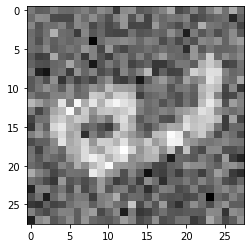

In [ ]:
noise_level = 0.3
emnist_test_with_noise = inject_noise(emnist_test.data, noise_level)
__ = plt.imshow(emnist_test_with_noise[0].reshape(28, 28).to("cpu"), cmap="gray")

In [ ]:
def get_accuracy_values_at_noise_level(noise_level):

  emnist_test_with_noise = inject_noise(emnist_test.data, noise_level)  # first, let's create noisy test images

  hidden_repr_layer_1_noisy = get_kth_layer_repr(emnist_test_with_noise, 0, device)  # here we compute the DBN representations
  hidden_repr_layer_2_noisy = get_kth_layer_repr(hidden_repr_layer_1_noisy, 1, device)
  hidden_repr_layer_3_noisy = get_kth_layer_repr(hidden_repr_layer_2_noisy, 2, device)

  predictions_first_hidden_noisy = linear1(hidden_repr_layer_1_noisy)  # here we use the previously-trained read-out classifiers
  predictions_second_hidden_noisy = linear2(hidden_repr_layer_2_noisy)
  predictions_third_hidden_noisy = linear3(hidden_repr_layer_3_noisy)

  accuracy_first_hidden = compute_accuracy(predictions_first_hidden_noisy, emnist_test.targets)
  accuracy_second_hidden = compute_accuracy(predictions_second_hidden_noisy, emnist_test.targets)
  accuracy_third_hidden = compute_accuracy(predictions_third_hidden_noisy, emnist_test.targets)

  predictions_ffnn_noisy = ffnn(emnist_test_with_noise.reshape((18800, 784)))  # we repeat a similar process for the feed-forward model
  accuracy_ffnn = compute_accuracy(predictions_ffnn_noisy, emnist_test.targets)

  return accuracy_first_hidden, accuracy_second_hidden, accuracy_third_hidden, accuracy_ffnn

In [ ]:
acc = get_accuracy_values_at_noise_level(0.3);
print("Accuracy of H1 read-out: %.3f" % acc[0])
print("Accuracy of H2 read-out: %.3f" % acc[1])
print("Accuracy of H3 read-out: %.3f" % acc[2])
print("Accuracy of FF network : %.3f" % acc[3])

Accuracy of H1 read-out: 0.630
Accuracy of H2 read-out: 0.647
Accuracy of H3 read-out: 0.669
Accuracy of FF network : 0.634


The function returns the accuracy values for the 4 models.
The accuracy values are very consistent between them, for the first one is observed 63%, for the second 64.7%, the third has the highest accuracy which is 66.9% and lastly the correpondant to the FNN 63.4% which is a little bit lower compared to the other classifiers.

Let's create the psychometric curves for the DBN (at different levels of internal representations) and for the feed-forward network:

In [ ]:
def plot_noise_robustness_curves(noise_levels):
  accuracy_values_first_hidden = []
  accuracy_values_second_hidden = []
  accuracy_values_third_hidden = []
  accuracy_values_ffnn = []

  for noise_level in noise_levels:
    acc = get_accuracy_values_at_noise_level(noise_level)
    accuracy_values_first_hidden.append(acc[0])
    accuracy_values_second_hidden.append(acc[1])
    accuracy_values_third_hidden.append(acc[2])
    accuracy_values_ffnn.append(acc[3])

  fig, ax = plt.subplots()
  ax.plot(range(len(noise_levels)), accuracy_values_first_hidden)
  ax.plot(range(len(noise_levels)), accuracy_values_second_hidden)
  ax.plot(range(len(noise_levels)), accuracy_values_third_hidden)
  ax.plot(range(len(noise_levels)), accuracy_values_ffnn)

  ax.set_title("Robustness to noise")
  ax.set_xlabel("Noise level (%)")
  ax.set_ylabel("Accuracy")
  plt.xticks(range(len(noise_levels)), [int(l*100) for l in noise_levels])
  plt.legend(["First hidden", "Second hidden", "Third hidden", "FFNN"])

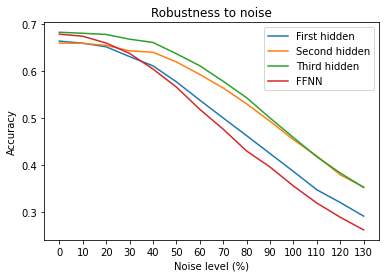

In [ ]:
noise_levels = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3]
plot_noise_robustness_curves(noise_levels)

It is observed that the model which is more robust to the noise is the third hidden, but as the noise level increases, it becomes comparable to the performance of the second hidden. On the other hand, the fist hidden and the FFNN have the worst performance.

## **Perturbing the models with adversarial attacks**

In [ ]:
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()

    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad

    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)

    # Return the perturbed image
    return perturbed_image

This function takes as inputs the image, the epsilon (the value we are going to use to modify the images), and the data_grad, which is the sign of the gradient, and it will return the perturbed image, with the minor modification to confuse our model to perform the classification correctly.

## **Adversarial Samples**

In [ ]:
class DBNWithReadOut(torch.nn.Module):
    def __init__(self, dbn_emnist, readouts, readout_level=0):
        super().__init__()
        self.readouts = readouts
        self.dbn_emnist = dbn_emnist
        self._require_grad()
        self.readout_level = readout_level

    def _require_grad(self):
      for rbm in self.dbn_emnist.rbm_layers:
        rbm.W.requires_grad_()
        rbm.h_bias.requires_grad_()

    def forward(self, image):
      """This forward pass uses probabilities instead of samples as RBM outputs
       to backpropagate the gradient"""
      p_v = image
      hidden_states = []
      for rbm in self.dbn_emnist.rbm_layers:
        p_v = p_v.view((p_v.shape[0], -1))  # flatten
        p_v, v = rbm(p_v)
        hidden_states.append(p_v)
      return self.readouts[self.readout_level].forward(hidden_states[self.readout_level])

This is an implementation of a DBN with readout, a type of generative deep learning model. The class has two main components: the DBN and the readout, which is a neural network layer responsible for the final classification. The DBN and readout are combined to form a complete image classification model. The forward method implements the network's forward pass, which takes an input image and returns the final classification result.

In [ ]:
dbn_with_readout = DBNWithReadOut(dbn_emnist, [linear1, linear2, linear3], readout_level=2)

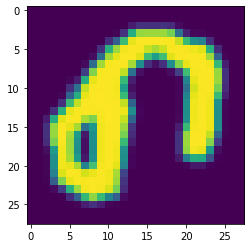

In [ ]:
test_sample_idx = 1
test_image = emnist_test.data[test_sample_idx].reshape(1, 784)
__ = plt.imshow(test_image.reshape(28,28).to('cpu'))

In [ ]:
attacked_model = ffnn

In [ ]:
attacked_model = dbn_with_readout

In [ ]:
test_image.requires_grad_()
model_outputs = attacked_model(test_image)
prediction = torch.argmax(model_outputs)
print(f"The prediction of the model for this sample is {prediction}.")

The prediction of the model for this clean sample is 39.


We are attacking the models created previously with adversarial examples. In this case, we are printing the visualizations of the modified images and the outputs, which correctly have been modified by the adversarial attack; in this case, even if, to the human eye, the modifications to the variables are not perceptible, we are cheating the model, and the outputs do not correspond with the correct classification.

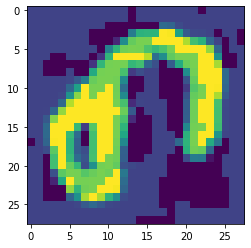

In [ ]:
epsilon = 0.2  # define strenght of the attack
test_image_label = emnist_test.targets[test_sample_idx].unsqueeze(0)  # get ground truth label for that image
loss_value = torch.nn.functional.cross_entropy(model_outputs, test_image_label)  # get loss value
attacked_model.zero_grad()
loss_value.backward()
image_grad = test_image.grad.data  # get the gradient of the pixels w.r.t. the loss
perturbed_image = fgsm_attack(test_image, epsilon, image_grad)

perturbed_image_np = perturbed_image.detach().to('cpu').numpy()
__ = plt.imshow(perturbed_image_np.reshape(28,28))

In [ ]:
model_outputs = attacked_model(perturbed_image.view((perturbed_image.shape[0], -1)))
print(f"The prediction of the model for the perturbed sample is {torch.argmax(model_outputs)}.")

The prediction of the model for the perturbed sample is 0.


##**Resisting to adversarial attacks**


In [ ]:
def test_robustness_to_attack(model, device, test_loader, epsilon, num_steps=0, verbose=True):
    correct = 0
    print_reconstruction = num_steps > 0

    for data, target in tqdm(test_loader):
        data, target = data.to(device), target.to(device)
        data = data.reshape(-1, 784)
        data.requires_grad = True  # Important for Attack

        output = model.forward(data)

        init_pred = torch.argmax(output)

        if (print_reconstruction and verbose):
          print("\nHere's the original sample:\n")
          plt.imshow(data[0].detach().to('cpu').numpy().reshape(28,28))
          plt.show()

        loss = functional.nll_loss(output, target)
        model.zero_grad()
        loss.backward()
        data_grad = data.grad.data  # collect the gradient of the input data
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        if (print_reconstruction and verbose):
            print("\nHere's a perturbed sample:\n")
            plt.imshow(perturbed_data[0].detach().to('cpu').numpy().reshape(28,28))
            plt.show()


        # If requested, reconstruct the input iterating forward-backward dynamics
        if num_steps > 0:
            for __ in range(0, num_steps):
                perturbed_data, __ = model.dbn_emnist.reconstruct(perturbed_data)
            if (print_reconstruction and verbose):
                print(f"\nHere's what a {num_steps}-steps reconstructed sample looks like:\n")
                plt.imshow(perturbed_data[0].detach().to('cpu').numpy().reshape(28,28))
                plt.show()
                print_reconstruction = False

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        # get the index of the max element in the output
        final_pred = output.max(1, keepdim=True)[1]
        final_pred = output.argmax(-1)
        correct += (final_pred == target).sum()

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader.sampler))
    print("\nEpsilon: {}\nTest Accuracy: {:.2f}%\n".format(epsilon, final_acc*100))

    return final_acc.item()

In [ ]:
test_loader = torch.utils.data.DataLoader(
    tv.datasets.EMNIST('data/', train=False, split="balanced", download=False, transform=tv.transforms.Compose([tv.transforms.ToTensor()])),
    batch_size=100, shuffle=True)

In [ ]:
final_acc = test_robustness_to_attack(ffnn, device,
                                      test_loader, epsilon=0.1,
                                      num_steps=0)

  0%|          | 0/188 [00:00<?, ?it/s]


Epsilon: 0.1
Test Accuracy: 19.05%



In [ ]:
final_acc = test_robustness_to_attack(dbn_with_readout, device,
                                      test_loader, epsilon=0.1,
                                      num_steps=0)

  0%|          | 0/188 [00:00<?, ?it/s]


Epsilon: 0.1
Test Accuracy: 46.62%



  0%|          | 0/188 [00:00<?, ?it/s]


Here's the original sample:



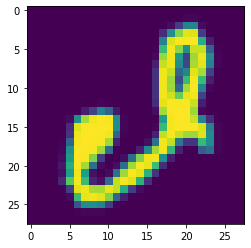


Here's a perturbed sample:



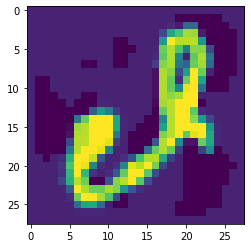


Here's what a 1-steps reconstructed sample looks like:



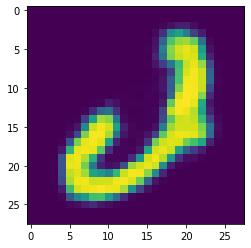


Epsilon: 0.1
Test Accuracy: 51.03%



In [ ]:
final_acc = test_robustness_to_attack(dbn_with_readout, device,
                                      test_loader, epsilon=0.1,
                                      num_steps=1)

Using the function created previously we are measuring the robustness of our models to the adversarial attacks, in the case of the FFNN we can observe an accuracy of 19.05% which is very low, it means that this model is not robust enough against this attacks, the read-out trained on the hidden representation of the DBN shows 46.62% of accuracy which is more than the double than the FFNN, the top-down reconstruction from the generative model shows a better accuracy of 51.03%.

## **Effect of the noise parameter $\epsilon$**

In [ ]:
epsilon_values = [0, 0.05, 0.10, 0.15, 0.20, 0.25]

def test_epsilon_values_effect(model, n_steps):
  accuracies = list()

  for eps in epsilon_values:
      acc = test_robustness_to_attack(model, device, test_loader, eps, num_steps=n_steps, verbose=False)
      accuracies.append(acc)

  return accuracies

In [ ]:
%%capture
accuracies_ffnn = test_epsilon_values_effect(ffnn, n_steps=0)
accuracies_dbn_0 = test_epsilon_values_effect(dbn_with_readout, n_steps=0)
accuracies_dbn_1 = test_epsilon_values_effect(dbn_with_readout, n_steps=1)

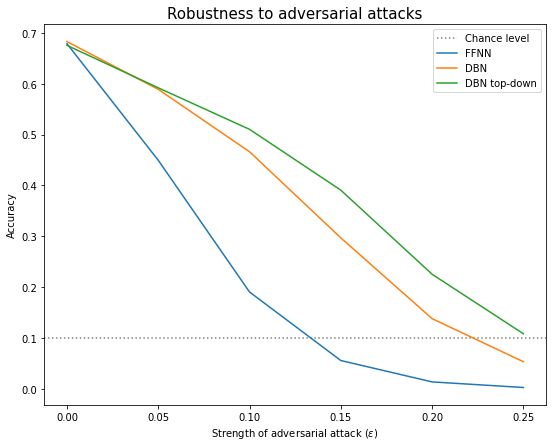

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(9, 7), sharey=True)

__ = ax.axhline(0.1, color='gray', linestyle=':')
__ = ax.plot(epsilon_values, accuracies_ffnn)
__ = ax.plot(epsilon_values, accuracies_dbn_0)
__ = ax.plot(epsilon_values, accuracies_dbn_1)
__ = ax.set_xlabel("Strength of adversarial attack ($\epsilon$)")
__ = ax.set_ylabel("Accuracy")
__ = ax.set_title("Robustness to adversarial attacks", {'fontsize': 15})
__ = ax.legend(["Chance level", "FFNN", "DBN", "DBN top-down"])

We can observe that the DBN top-down is the best among all the models, even when the strength of the adversarial attack increase is still above the threshold; the second best performance is for the DBN, and the last one is for the FFNN, which after the increase on the .1 of the epsilon value of the effect it decreases in a very rapid fashion.

# **Improving the DBN**

The goal of a Deep Belief Network (DBN) is to learn and understand data patterns. This is accomplished by training multiple layers, each of which learns to recognize and represent more complex patterns in the data. The first stage of training involves unsupervised learning to train each layer, followed by labeled data to fine-tune the network for specific tasks such as prediction or classification. The end result is a multi-layer neural network capable of making predictions based on the patterns discovered in the data.

In [ ]:
dbn_emnist = DBN(visible_units=28*28,
                hidden_units=[500, 800, 1000, 1200],
                k=1,
                learning_rate=0.01,
                learning_rate_decay=True,
                initial_momentum=0.9,
                final_momentum=0.99,
                weight_decay=0.001,
                xavier_init=True,
                increase_to_cd_k=True,
                use_gpu=torch.cuda.is_available())

The DBN has 28x28 visible units (image pixels of 28x28) and four hidden layers of 500, 800, 1000, and 1200 units. The network trains using contrastive divergence with k=1 and has a learning rate of 0.01. The network's momentum begins at 0.9 and gradually increases to 0.99. The weight decay is set to 0.001, and Xavier initialization is used. The computations are performed on a GPU.

In [ ]:
num_epochs = 50
batch_size = 100

dbn_emnist.train_static(
    emnist_train.data,
    emnist_train.targets,
    num_epochs,
    batch_size
)

--------------------
Training RBM layer 1
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |1.0059     |0.0393       |12.4702   |0.3890     |
|20    |0.9628     |0.0349       |6.1846   |0.1487     |
|30    |0.9488     |0.0331       |4.1174   |0.1037     |
|40    |0.9421     |0.0334       |3.1251   |0.0714     |
|50    |0.9372     |0.0332       |2.4518   |0.0597     |
--------------------
Training RBM layer 2
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |1.3630     |0.0328       |15.1769   |0.4328     |
|20    |1.2837     |0.0324       |7.2264   |0.1692     |
|30    |1.2705     |0.0323       |4.8665   |0.1341     |
|40    |1.2617     |0.0314       |3.6252   |0.0868     |
|50    |1.2596     |0.0318       |2.8584   |0.0721     |
--------------------
Training RBM layer 3
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |0.7092     |0.0202       |21.4984   |0.7289     |
|20    |0.6774     |0.0200       |10.5534   |0.2958     |
|30    |0.66

Training is divided into four stages, one for each hidden layer. The batch size is 100 and the number of training epochs is set to 50. For each hidden layer at each epoch, the output displays the average reconstruction error, standard deviation of reconstruction error, mean gradient, and standard deviation of gradient. The reconstruction error and gradients are indicators of how well the network can reconstruct the input data, and their values decrease as training progresses.

The reconstruction error of the first hidden layer starts at 1.0059 and the standard deviation is 0.0393, and it decreases to 0.9372 and 0.0332 at the end of the training. The mean gradient starts at 12.4702 and the standard deviation is 0.3890, and it decreases to 2.4518. The second layer begins with a reconstruction error of 1.3630 and a standard deviation of 0.0328 and decreases to 1.2596 and 0.0318 at the end of training, while the mean gradient begins at 15.1769 and decreases to 2.8584. The third layer, starts with a reconstruction error of 0.7092 and standard deviation of 0.0202, and it decreases to 0.6619  and 0.0187 at the end of the training, the mean gradient starts at 21.4984 and standard deviation of 0.7289 and it decreases to 4.1994.The fourth layer, starts with a reconstruction error of 0.5872 and standard deviation of 0.0146, and it decreases to 0.5500  and 0.0137 at the end of the training, the mean gradient starts at 22.9417 and standard deviation of 0.8781 and it decreases to 4.4166.

## **Linear read-out**

The linear readout is the final step in a DBN that combines the information from previous layers to make a prediction. It uses a simple mathematical formula to combine the information and produce a single output. This is often used in regression problems where the answer is a continuous value. The formula used is optimized during training to improve the accuracy of the predictions.

In [ ]:
def get_kth_layer_repr(input, k, device):
  flattened_input = input.view((input.shape[0], -1)).type(torch.FloatTensor).to(device)
  hidden_repr, __ = dbn_emnist.rbm_layers[k].to_hidden(flattened_input)  # here we access the RBM object
  return hidden_repr

This code defines the function "get kth layer repr," which takes three arguments: input, k (hidden layer index), and device (GPU or CPU).
The function flattens the tensor input. The input is then sent to the device. The function then invokes the "to hidden" method of the DBN's kth RBM object. The method returns the hidden representation of the input, which serves as the function's output.

In [ ]:
hidden_repr_layer_1 = get_kth_layer_repr(emnist_train.data, 0, device)
hidden_repr_layer_2 = get_kth_layer_repr(hidden_repr_layer_1, 1, device)
hidden_repr_layer_3 = get_kth_layer_repr(hidden_repr_layer_2, 2, device)

It calls the function "get kth layer repr" three times, passing in the train data each time. In each call, data is used as the input, the index of the hidden layer (0,1,2 respectively), and goes to the device.
We can use these hidden representations to classify the images.

In [ ]:
class LinearModel(torch.nn.Module):
  def __init__(self, last_layer_size):
    super().__init__()
    self.linear = torch.nn.Linear(last_layer_size, 47)

  def forward(self, x):
    return self.linear(x)

This code declares the "LinearModel" class. This class defines a simple linear model for classification tasks using the balanced dataset's 47 classes.
The class also defines a forward method that takes the input tensor as an argument, applies the linear layer to it, and returns the result.
This linear model can be trained on the hidden representations obtained from the layers and used to classify the images.

In [ ]:
layer_size = dbn_emnist.rbm_layers[0].W.shape[1]
linear1 = LinearModel(layer_size).to(device)

layer_size = dbn_emnist.rbm_layers[1].W.shape[1]
linear2 = LinearModel(layer_size).to(device)

layer_size = dbn_emnist.rbm_layers[2].W.shape[1]
linear3 = LinearModel(layer_size).to(device)

This code generates three instances of the "LinearModel" class, one for each of the DBN's hidden layers.
This linear model can be trained and used to classify images using the hidden representations obtained from the various layers.

In [ ]:
def train(network, input, epochs=2000):
  optimizer = torch.optim.SGD(network.parameters(), lr=0.05)
  loss_fn = torch.nn.CrossEntropyLoss()

  for epoch in range(epochs):
    optimizer.zero_grad()
    predictions = network(input).squeeze()
    targets = emnist_train.targets.reshape(predictions.shape[0])  # here are the labels
    loss = loss_fn(predictions, targets)
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
      print("epoch : {:3d}/{}, loss = {:.4f}".format(epoch + 1, epochs, loss))

This function train is used to train a neural network. It takes four arguments: the network, inputs, targets, and epochs (in this case, 1500).
The function begins by defining an optimizer (SGD with a learning rate of 0.05) and a loss function (cross-entropy loss).
Every 100 epochs, the code prints the current epoch number as well as the loss value. This allows to assess the progress of the training process and determine whether the network is overfitting or underfitting.

In [ ]:
train(linear1, hidden_repr_layer_1)
train(linear2, hidden_repr_layer_2)
train(linear3, hidden_repr_layer_3)

epoch :   1/2000, loss = 1.2679
epoch : 101/2000, loss = 1.2533
epoch : 201/2000, loss = 1.2400
epoch : 301/2000, loss = 1.2278
epoch : 401/2000, loss = 1.2164
epoch : 501/2000, loss = 1.2059
epoch : 601/2000, loss = 1.1961
epoch : 701/2000, loss = 1.1869
epoch : 801/2000, loss = 1.1783
epoch : 901/2000, loss = 1.1702
epoch : 1001/2000, loss = 1.1625
epoch : 1101/2000, loss = 1.1552
epoch : 1201/2000, loss = 1.1483
epoch : 1301/2000, loss = 1.1417
epoch : 1401/2000, loss = 1.1355
epoch : 1501/2000, loss = 1.1295
epoch : 1601/2000, loss = 1.1238
epoch : 1701/2000, loss = 1.1183
epoch : 1801/2000, loss = 1.1130
epoch : 1901/2000, loss = 1.1080
epoch :   1/2000, loss = 1.2537
epoch : 101/2000, loss = 1.2398
epoch : 201/2000, loss = 1.2271
epoch : 301/2000, loss = 1.2153
epoch : 401/2000, loss = 1.2045
epoch : 501/2000, loss = 1.1944
epoch : 601/2000, loss = 1.1850
epoch : 701/2000, loss = 1.1762
epoch : 801/2000, loss = 1.1678
epoch : 901/2000, loss = 1.1600
epoch : 1001/2000, loss = 1.15

We have linear models, linear1, linear2, and linear3, using the hidden representations of the first, second, and third layers of a pre-trained model respectively. The input for each linear model is the hidden representation of the corresponding layer, and the targets are the labels of the training data. The training process is done using stochastic gradient descent (SGD) as the optimization algorithm and cross-entropy loss as the loss function. The training process is performed for 2000 epochs and the loss is printed every 100 epochs.

In [ ]:
hidden_repr_layer_1_test = get_kth_layer_repr(emnist_test.data, 0, device)
hidden_repr_layer_2_test = get_kth_layer_repr(hidden_repr_layer_1_test, 1, device)
hidden_repr_layer_3_test = get_kth_layer_repr(hidden_repr_layer_2_test, 2, device)

These variables, "hidden_repr_layer_1_test", "hidden_repr_layer_2_test" and "hidden_repr_layer_3_test" store the hidden representations of the test data at different layers in the DBN.

In [ ]:
# here we compute the predictions
predictions_test1 = linear1(hidden_repr_layer_1_test)
predictions_test2 = linear2(hidden_repr_layer_2_test)
predictions_test3 = linear3(hidden_repr_layer_3_test)

Here the linear models created earlier are applied to the hidden representations of the test data, and the predictions are stored in the variables.
These predictions can then be compared to the true labels of the test data to evaluate the performance of the linear models.

In [ ]:
def compute_accuracy(predictions_test, targets):
  predictions_indices = predictions_test.max(axis=1).indices  # convert probabilities to indices
  accuracy = (predictions_indices == targets).sum() / len(targets)
  return accuracy.item()

The function "compute_accuracy" that takes in two arguments the predictions_test and the targets.
It converts the predictions from a probability distribution to the indices of the classes that have the highest probability, and compares these indices to the true labels and average of the correct predictions. This average represents the accuracy of the predictions.

In [ ]:
compute_accuracy(predictions_test1, emnist_test.targets)

0.6876063942909241

In [ ]:
compute_accuracy(predictions_test2, emnist_test.targets)

0.6928723454475403

In [ ]:
compute_accuracy(predictions_test3, emnist_test.targets)

0.7008510231971741

Compared to the first model of DBN, the accuracies have successfully improved in the first is 68.76%, the second is 69.28%, and the third is 70.08%.

## **Comparison with a feed-forward model**

In [ ]:
class Feedforward(torch.nn.Module):
  def __init__(self, first_hidden_layer_size, second_hidden_layer_size, third_hidden_layer_size):
    super().__init__()
    self.first_hidden = torch.nn.Linear(784, first_hidden_layer_size)
    self.second_hidden = torch.nn.Linear(first_hidden_layer_size, second_hidden_layer_size)
    self.third_hidden = torch.nn.Linear(second_hidden_layer_size, third_hidden_layer_size)
    self.output = torch.nn.Linear(third_hidden_layer_size, 47)

  def forward(self, input):
    relu = torch.nn.ReLU()
    first_hidden_repr = relu(self.first_hidden(input))
    second_hidden_repr = relu(self.second_hidden(first_hidden_repr))
    third_hidden_repr = relu(self.third_hidden(second_hidden_repr))
    output = self.output(third_hidden_repr)
    return output

It defines a Feedforward neural network for classification tasks with 47 classes. It takes in the input as an argument and applies the Linear layers to it with a non-linear activation function ReLU after each linear layer and returns the output.

In [ ]:
ffnn = Feedforward(500, 800, 1000).to(device)

In [ ]:
train(ffnn, emnist_train.data.reshape((112800, 784)), epochs=2000)

epoch :   1/2000, loss = 3.8503
epoch : 101/2000, loss = 3.8299
epoch : 201/2000, loss = 3.7726
epoch : 301/2000, loss = 3.5108
epoch : 401/2000, loss = 2.7781
epoch : 501/2000, loss = 2.1051
epoch : 601/2000, loss = 1.7672
epoch : 701/2000, loss = 1.5843
epoch : 801/2000, loss = 1.4605
epoch : 901/2000, loss = 1.3738
epoch : 1001/2000, loss = 1.3037
epoch : 1101/2000, loss = 1.2461
epoch : 1201/2000, loss = 1.1969
epoch : 1301/2000, loss = 1.1528
epoch : 1401/2000, loss = 1.1121
epoch : 1501/2000, loss = 1.0738
epoch : 1601/2000, loss = 1.0377
epoch : 1701/2000, loss = 1.0036
epoch : 1801/2000, loss = 0.9715
epoch : 1901/2000, loss = 0.9432


In [ ]:
predictions_ffnn = ffnn(emnist_test.data.reshape((18800, 784)))

In [ ]:
compute_accuracy(predictions_ffnn, emnist_test.targets)

0.725372314453125

We can observe that the accuracy of the FNN is 72.53%, which indeed is better than the previous FNN.

## **Robustness to noise**

In [ ]:
def inject_noise(emnist_data, noise_level):
  random_gaussian_tensor = torch.randn(emnist_data.shape, device = device)*noise_level
  return emnist_data + random_gaussian_tensor

This function is used to artificially add noise (gaussian) to the training data to improve the robustness of the model.

Plotting the noisy image:

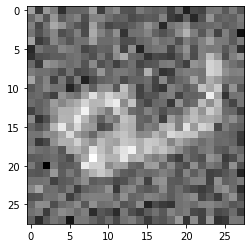

In [ ]:
noise_level = 0.3
emnist_test_with_noise = inject_noise(emnist_test.data, noise_level)
__ = plt.imshow(emnist_test_with_noise[0].reshape(28, 28).to("cpu"), cmap="gray")

In [ ]:
def get_accuracy_values_at_noise_level(noise_level):

  emnist_test_with_noise = inject_noise(emnist_test.data, noise_level)  # first, let's create noisy test images

  hidden_repr_layer_1_noisy = get_kth_layer_repr(emnist_test_with_noise, 0, device)  # here we compute the DBN representations
  hidden_repr_layer_2_noisy = get_kth_layer_repr(hidden_repr_layer_1_noisy, 1, device)
  hidden_repr_layer_3_noisy = get_kth_layer_repr(hidden_repr_layer_2_noisy, 2, device)

  predictions_first_hidden_noisy = linear1(hidden_repr_layer_1_noisy)  # here we use the previously-trained read-out classifiers
  predictions_second_hidden_noisy = linear2(hidden_repr_layer_2_noisy)
  predictions_third_hidden_noisy = linear3(hidden_repr_layer_3_noisy)

  accuracy_first_hidden = compute_accuracy(predictions_first_hidden_noisy, emnist_test.targets)
  accuracy_second_hidden = compute_accuracy(predictions_second_hidden_noisy, emnist_test.targets)
  accuracy_third_hidden = compute_accuracy(predictions_third_hidden_noisy, emnist_test.targets)

  predictions_ffnn_noisy = ffnn(emnist_test_with_noise.reshape((18800, 784)))  # we repeat a similar process for the feed-forward model
  accuracy_ffnn = compute_accuracy(predictions_ffnn_noisy, emnist_test.targets)

  return accuracy_first_hidden, accuracy_second_hidden, accuracy_third_hidden, accuracy_ffnn

In [ ]:
acc = get_accuracy_values_at_noise_level(0.3);
print("Accuracy of H1 read-out: %.3f" % acc[0])
print("Accuracy of H2 read-out: %.3f" % acc[1])
print("Accuracy of H3 read-out: %.3f" % acc[2])
print("Accuracy of FF network : %.3f" % acc[3])

Accuracy of H1 read-out: 0.656
Accuracy of H2 read-out: 0.678
Accuracy of H3 read-out: 0.690
Accuracy of FF network : 0.677


The function returns the accuracy values for the 4 models. We can notice an improvement in all the models with respest to the ones above.
The accuracy values are less consistent between them respect to the last models, for the first one is observed 65.6%, for the second 67.8%, the third maintains the highest accuracy which is 69% and lastly the correpondant to the FNN 67.7% which with the improvement becomes more powerful than the classifier 1, and almost at the same level as the second.

In [ ]:
def plot_noise_robustness_curves(noise_levels):
  accuracy_values_first_hidden = []
  accuracy_values_second_hidden = []
  accuracy_values_third_hidden = []
  accuracy_values_ffnn = []

  for noise_level in noise_levels:
    acc = get_accuracy_values_at_noise_level(noise_level)
    accuracy_values_first_hidden.append(acc[0])
    accuracy_values_second_hidden.append(acc[1])
    accuracy_values_third_hidden.append(acc[2])
    accuracy_values_ffnn.append(acc[3])

  fig, ax = plt.subplots()
  ax.plot(range(len(noise_levels)), accuracy_values_first_hidden)
  ax.plot(range(len(noise_levels)), accuracy_values_second_hidden)
  ax.plot(range(len(noise_levels)), accuracy_values_third_hidden)
  ax.plot(range(len(noise_levels)), accuracy_values_ffnn)

  ax.set_title("Robustness to noise")
  ax.set_xlabel("Noise level (%)")
  ax.set_ylabel("Accuracy")
  plt.xticks(range(len(noise_levels)), [int(l*100) for l in noise_levels])
  plt.legend(["First hidden", "Second hidden", "Third hidden", "FFNN"])

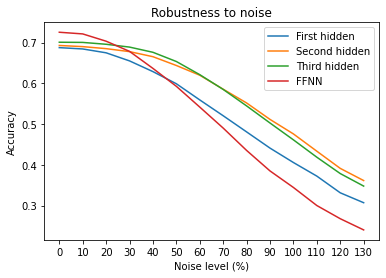

In [ ]:
noise_levels = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3]
plot_noise_robustness_curves(noise_levels)

We observe a generalized increase in the performance of all the models concerning the first models without the modifications. It is observed that the model in this case, which is more robust to the noise, is the second hidden but performs slightly better than the third hidden. On the other hand, the first hidden and the FFNN have the worst performance, with the same output as before.

## **Perturbing the models with adversarial attacks**

In [ ]:
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()

    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad

    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)

    # Return the perturbed image
    return perturbed_image

This function takes as inputs the image, the epsilon (the value we are going to use to modify the images), and the data_grad, which is the sign of the gradient, and it will return the perturbed image, with the minor modification to confuse our model to perform the classification correctly.

## **Adversarial Samples**

In [ ]:
class DBNWithReadOut(torch.nn.Module):
    def __init__(self, dbn_emnist, readouts, readout_level=0):
        super().__init__()
        self.readouts = readouts
        self.dbn_emnist = dbn_emnist
        self._require_grad()
        self.readout_level = readout_level

    def _require_grad(self):
      for rbm in self.dbn_emnist.rbm_layers:
        rbm.W.requires_grad_()
        rbm.h_bias.requires_grad_()

    def forward(self, image):
      """This forward pass uses probabilities instead of samples as RBM outputs
       to backpropagate the gradient"""
      p_v = image
      hidden_states = []
      for rbm in self.dbn_emnist.rbm_layers:
        p_v = p_v.view((p_v.shape[0], -1))  # flatten
        p_v, v = rbm(p_v)
        hidden_states.append(p_v)
      return self.readouts[self.readout_level].forward(hidden_states[self.readout_level])

This is an implementation of a DBN with readout, a type of generative deep learning model. The class has two main components: the DBN and the readout, which is a neural network layer responsible for the final classification. The DBN and readout are combined to form a complete image classification model. The forward method implements the network's forward pass, which takes an input image and returns the final classification result.

In [ ]:
dbn_with_readout = DBNWithReadOut(dbn_emnist, [linear1, linear2, linear3], readout_level=2)

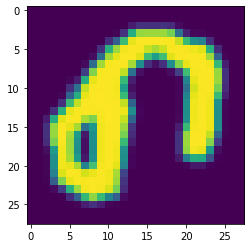

In [ ]:
test_sample_idx = 1
test_image = emnist_test.data[test_sample_idx].reshape(1, 784)
__ = plt.imshow(test_image.reshape(28,28).to('cpu'))

In [ ]:
attacked_model = ffnn

In [ ]:
attacked_model = dbn_with_readout

In [ ]:
test_image.requires_grad_()
model_outputs = attacked_model(test_image)
prediction = torch.argmax(model_outputs)
print(f"The prediction of the model for this clean sample is {prediction}.")

The prediction of the model for this clean sample is 39.


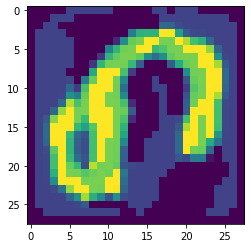

In [ ]:
epsilon = 0.2  # define strenght of the attack
test_image_label = emnist_test.targets[test_sample_idx].unsqueeze(0)  # get ground truth label for that image
loss_value = torch.nn.functional.cross_entropy(model_outputs, test_image_label)  # get loss value
attacked_model.zero_grad()
loss_value.backward()
image_grad = test_image.grad.data  # get the gradient of the pixels w.r.t. the loss
perturbed_image = fgsm_attack(test_image, epsilon, image_grad)

perturbed_image_np = perturbed_image.detach().to('cpu').numpy()
__ = plt.imshow(perturbed_image_np.reshape(28,28))

In [ ]:
model_outputs = attacked_model(perturbed_image.view((perturbed_image.shape[0], -1)))
print(f"The prediction of the model for the perturbed sample is {torch.argmax(model_outputs)}.")

The prediction of the model for the perturbed sample is 0.


We are attacking the models created previously with adversarial examples. In this case, we are printing the visualizations of the modified images and the outputs, which correctly have been modified by the adversarial attack; in this case, even if, to the human eye, the modifications to the variables are not perceptible, we are cheating the model, and the outputs do not correspond with the correct classification.

##**Resisting to adversarial attacks**

In [ ]:
def test_robustness_to_attack(model, device, test_loader, epsilon, num_steps=0, verbose=True):
    correct = 0
    print_reconstruction = num_steps > 0

    for data, target in tqdm(test_loader):
        data, target = data.to(device), target.to(device)
        data = data.reshape(-1, 784)
        data.requires_grad = True  # Important for Attack

        output = model.forward(data)

        init_pred = torch.argmax(output)

        if (print_reconstruction and verbose):
          print("\nHere's the original sample:\n")
          plt.imshow(data[0].detach().to('cpu').numpy().reshape(28,28))
          plt.show()

        loss = functional.nll_loss(output, target)
        model.zero_grad()
        loss.backward()
        data_grad = data.grad.data  # collect the gradient of the input data
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        if (print_reconstruction and verbose):
            print("\nHere's a perturbed sample:\n")
            plt.imshow(perturbed_data[0].detach().to('cpu').numpy().reshape(28,28))
            plt.show()


        # If requested, reconstruct the input iterating forward-backward dynamics
        if num_steps > 0:
            for __ in range(0, num_steps):
                perturbed_data, __ = model.dbn_emnist.reconstruct(perturbed_data)
            if (print_reconstruction and verbose):
                print(f"\nHere's what a {num_steps}-steps reconstructed sample looks like:\n")
                plt.imshow(perturbed_data[0].detach().to('cpu').numpy().reshape(28,28))
                plt.show()
                print_reconstruction = False

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        # get the index of the max element in the output
        final_pred = output.max(1, keepdim=True)[1]
        final_pred = output.argmax(-1)
        correct += (final_pred == target).sum()

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader.sampler))
    print("\nEpsilon: {}\nTest Accuracy: {:.2f}%\n".format(epsilon, final_acc*100))

    return final_acc.item()

In [ ]:
test_loader = torch.utils.data.DataLoader(
    tv.datasets.EMNIST('data/', train=False, split="balanced", download=False, transform=tv.transforms.Compose([tv.transforms.ToTensor()])),
    batch_size=100, shuffle=True)

In [ ]:
final_acc = test_robustness_to_attack(ffnn, device,
                                      test_loader, epsilon=0.1,
                                      num_steps=0)

  0%|          | 0/188 [00:00<?, ?it/s]


Epsilon: 0.1
Test Accuracy: 20.29%



In [ ]:
final_acc = test_robustness_to_attack(dbn_with_readout, device,
                                      test_loader, epsilon=0.1,
                                      num_steps=0)

  0%|          | 0/188 [00:00<?, ?it/s]


Epsilon: 0.1
Test Accuracy: 47.78%



  0%|          | 0/188 [00:00<?, ?it/s]


Here's the original sample:



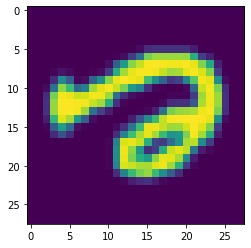


Here's a perturbed sample:



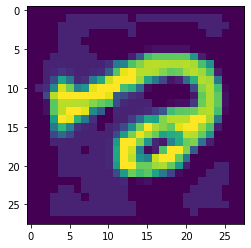


Here's what a 1-steps reconstructed sample looks like:



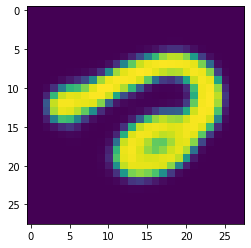


Epsilon: 0.1
Test Accuracy: 55.43%



In [ ]:
final_acc = test_robustness_to_attack(dbn_with_readout, device,
                                      test_loader, epsilon=0.1,
                                      num_steps=1)

With the new parameters using for the models, we can observe that it has improved the robustness of the models to the adversarial attacks, in the case of the FFNN we can observe an accuracy of 20.29% which is very low, it means that this model is not robust enough against this attacks, the read-out trained on the hidden representation of the DBN shows 47.78% of accuracy which is more than the double than the FFNN, the top-down reconstruction from the generative model shows a better accuracy of 55.43% which is the highest among all of them.

## **Effect of the noise parameter $\epsilon$**

In [ ]:
epsilon_values = [0, 0.05, 0.10, 0.15, 0.20, 0.25]

def test_epsilon_values_effect(model, n_steps):
  accuracies = list()

  for eps in epsilon_values:
      acc = test_robustness_to_attack(model, device, test_loader, eps, num_steps=n_steps, verbose=False)
      accuracies.append(acc)

  return accuracies

In [ ]:
%%capture
accuracies_ffnn = test_epsilon_values_effect(ffnn, n_steps=0)
accuracies_dbn_0 = test_epsilon_values_effect(dbn_with_readout, n_steps=0)
accuracies_dbn_1 = test_epsilon_values_effect(dbn_with_readout, n_steps=1)

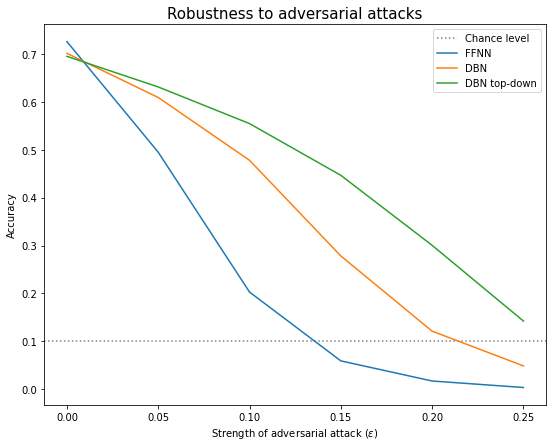

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(9, 7), sharey=True)

__ = ax.axhline(0.1, color='gray', linestyle=':')
__ = ax.plot(epsilon_values, accuracies_ffnn)
__ = ax.plot(epsilon_values, accuracies_dbn_0)
__ = ax.plot(epsilon_values, accuracies_dbn_1)
__ = ax.set_xlabel("Strength of adversarial attack ($\epsilon$)")
__ = ax.set_ylabel("Accuracy")
__ = ax.set_title("Robustness to adversarial attacks", {'fontsize': 15})
__ = ax.legend(["Chance level", "FFNN", "DBN", "DBN top-down"])

We can observe a slight improvement in the robustness of all the models. The DBN top-down is the best among all the models, even when the strength of the adversarial attack increase is still above the threshold; the second best performance is for the DBN, and the last one is for the FFNN, but now we can notice the rapid decrease in the robustness reaching an epsilon value of 0.14 approximately.

# **CONCLUSIONS**

In the development of this work I performed two different configurations for the models, in the first DBN I used 28x28 visible units (image pixels of 28x28) and three hidden layers of 400, 500, and 800 units. The network trains using contrastive divergence with k=1 and has a learning rate of 0.1. The network's momentum begins at 0.5 and gradually increases to 0.95. The weight decay is set to 0.0001, and no Xavier initialization is used. The computations are performed on a GPU. With this DBN I performed three read-out classifiers, subsequentely I developed a FFNN using 500 neurons in the first hidden layer, 800 neurons in the second hidden layer, and 1000 neurons in the final hidden layer. \\
In the searching of an improvement on the general performance I modified the DBN with the following changes 28x28 visible units (image pixels of 28x28) and four hidden layers of 500, 800, 1000, and 1200 units. The network trains using contrastive divergence with k=1 and has a learning rate of 0.01. The network's momentum begins at 0.9 and gradually increases to 0.99. The weight decay is set to 0.001, and Xavier initialization is used. The computations are performed on a GPU and for the FFNN I used three hidden layers of 500, 800, 1000 units respectively, and 2000 of epochs. \\
The best performance among all the models to be robust to the noise was the second hidden with the second configuration with an accuracy of 67.8% and the model most robust against the adversarial attacks was the DBN top-down with also the second configuration and 55.43% of accuracy. \\

# **REFERENCES**

Cohen, G., Afshar, S., Tapson, J., & van Schaik, A. (2017). EMNIST: an extension of MNIST to handwritten letters. Retrieved from http://arxiv.org/abs/1702.05373